In [124]:

#  Configuración y carga de librerías

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")  # Oculta todos los warnings

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb


In [105]:
# Carga de datos
df = pd.read_csv('../data/combined_sleep_dataset.csv')

In [106]:
# Selección de features y target

# Variables fuertes identificadas en el EDA
features = [
    'Physical Activity Level',
    'Daily Steps',
    'Blood Pressure',
    'Heart Rate',
    'Age',
    'Sleep Duration',
    'Quality of Sleep',
    'Stress Level',
    'BMI Category'
]

X = df[features]
y = df['Sleep_disorder']

In [107]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [108]:
# Pipeline de preprocesamiento + modelo

pipe = Pipeline([
    ('scaler', StandardScaler()),                     # Escalado de variables
    ('clf', RandomForestClassifier(random_state=42))   # Modelo
])


# Búsqueda de hiperparámetros (opcional)

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_leaf': [1, 3]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)




Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}


In [109]:

# Evaluación en set de test

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))




=== Classification Report ===
              precision    recall  f1-score   support

           0      0.573     0.724     0.640       152
           1      0.182     0.108     0.136        37
           2      0.000     0.000     0.000        23
           3      0.492     0.586     0.535        99
           4      0.100     0.047     0.063        43
           5      0.910     0.929     0.919        98

    accuracy                          0.586       452
   macro avg      0.376     0.399     0.382       452
weighted avg      0.522     0.586     0.549       452



- **Precision**: La clase **5** tiene la mejor precisión (0.910), pero **1, 2 y 4** son muy bajas.
- **Recall**: La clase **0** se identifica bien (0.724), pero la clase **2** no se detecta en absoluto (0.000).
- **F1-score**: Buen rendimiento en la clase **5** (0.919), pero **1, 2 y 4** muestran problemas.

- **Accuracy**: El modelo acierta un **58.6%** de los casos.
- **Macro avg**: Rendimiento promedio bajo (**0.382 en F1-score**).
- **Weighted avg**: Algo más representativo (**0.549 en F1-score**).
- El modelo funciona bien en la clase **5**, aceptable en **0 y 3**, pero falla en **1, 2 y 4**. 



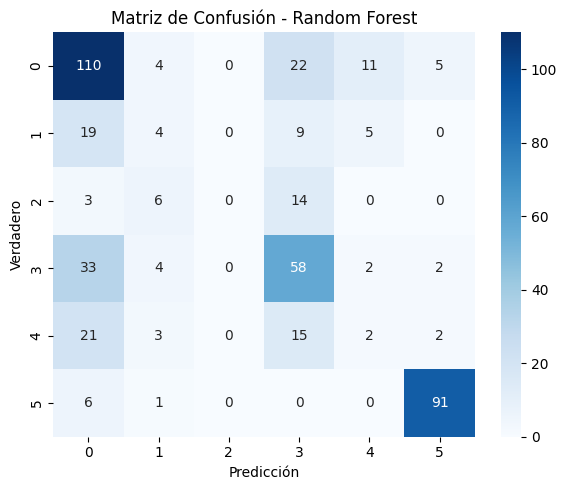

In [110]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Random Forest')
plt.tight_layout()
plt.show()

###  Matriz de Confusión (Random Forest)

- **Ejes**  
  - **Filas (verdadero)**: clase real de cada paciente (0–5).  
  - **Columnas (predicción)**: clase predicha por el modelo.

- **Clases**  
  0 = Insomnia  
  1 = Narcolepsy  
  2 = No Disorder  
  3 = Obstructive Sleep Apnea  
  4 = Restless Leg Syndrome  
  5 = Sleep Apnea

- El modelo **acierta muy bien** en **Insomnia (0)** y **Sleep Apnea (5)**.  
- **Obstructive Sleep Apnea (3)** se detecta moderadamente, pero hay mucha confusión con Insomnia.  
- Las clases **intermedias** (1, 2, 4) tienen un rendimiento **muy pobre**:  
  - **No Disorder (2)** no se reconoce en absoluto.  
  - **Narcolepsy (1)** y **RLS (4)** apenas se identifican.  
- Para mejorar, convendría:  
  1. **Reequilibrar** clases minoritarias (oversampling, penalización de clase).  
  2. **Añadir o crear features** que diferencien mejor las clases raras.  
  3. **Probar otros modelos** o ajustes de hiperparámetros más agresivos.  


---


#### Clasificación con XGBoost

In [111]:
# Selección de features y target
features = [
    'Physical Activity Level',
    'Daily Steps',
    'Blood Pressure',
    'Heart Rate',
    'Age',
    'Sleep Duration',
    'Quality of Sleep',
    'Stress Level',
    'BMI Category'
]
X = df[features]
y = df['Sleep_disorder']

In [112]:
# Train/Test split (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [113]:
#  Definición del modelo XGBoost
xgb = XGBClassifier(
    objective='multi:softmax',    # clasificación multiclase
    num_class=len(y.unique()),    # número de clases
    eval_metric='mlogloss',       # métrica interna
    use_label_encoder=False,
    random_state=42
)

# Grid Search de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Mejores parámetros XGBoost:", grid.best_params_)

# Evaluación en conjunto de test
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)

print("\n=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred, digits=3))




Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0      0.628     0.678     0.652       152
           1      0.182     0.054     0.083        37
           2      0.000     0.000     0.000        23
           3      0.489     0.697     0.575        99
           4      0.194     0.163     0.177        43
           5      0.910     0.929     0.919        98

    accuracy                          0.602       452
   macro avg      0.401     0.420     0.401       452
weighted avg      0.549     0.602     0.568       452



- **Fitting**: 5 folds, 36 candidatos, 180 combinaciones probadas.
- **Mejores parámetros**:  
  - `learning_rate`: 0.2  
  - `max_depth`: 3  
  - `n_estimators`: 100  
  - `subsample`: 0.8  

#### Evaluación Global
- **Accuracy**: **60.2%**
- **Macro avg**:  
  - Precision: **0.401**  
  - Recall: **0.420**  
  - F1-score: **0.401**
- **Weighted avg**:  
  - Precision: **0.549**  
  - Recall: **0.602**  
  - F1-score: **0.568**

#### Conclusión
- Rendimiento sólido en la clase **5**.
- **Mejoras necesarias** para las clases **1, 2 y 4**, que tienen bajo recall y precisión.
- Posibles estrategias: ajustar hiperparámetros, mejorar balance de clases, probar otros enfoques.



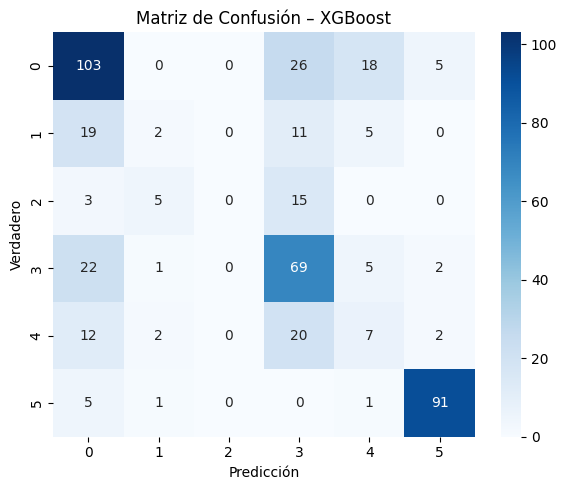

In [114]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=best_xgb.classes_,
    yticklabels=best_xgb.classes_
)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión – XGBoost')
plt.tight_layout()
plt.show()

#### Resumen de la Matriz de Confusión (XGBoost)

- **Sleep Apnea (5)** y **Obstructive Sleep Apnea (3)** son los más confiables, con OSA mejorado a 69 aciertos.  
- **Insomnia (0)** sigue siendo razonablemente bien clasificada (103 TP).  
- **No Disorder (2)** y **Narcolepsy (1)** no se reconocen correctamente; permanecen ausentes o casi ausentes en sus propios bins.  
- **RLS (4)** mejora algo (7 TP vs 2 con RF) pero sigue siendo débil.  
- Para afinar el modelo convendría:
  1. Reequilibrar clases muy minoritarias.  
  2. Incorporar nuevas features o generar interacciones que distingan mejor las clases con bajo rendimiento.  
  3. Explorar ajustes adicionales de hiperparámetros o técnicas de ensamblado.  


----

In [ ]:
# Carga y split

features = [
    'Physical Activity Level','Daily Steps','Blood Pressure','Heart Rate',
    'Age','Sleep Duration','Quality of Sleep','Stress Level','BMI Category'
]
X = df[features]
y = df['Sleep_disorder']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7.2 Pipeline: SMOTE → XGBoost con scale_pos_weight por clase
#    calculamos ratio para cada clase
from collections import Counter
counts = Counter(y_train)
# scale_pos_weight para multiclass se gestiona con 'scale_pos_weight' como lista:
# ratio = [total_neg/total_pos] por cada clase
total = sum(counts.values())
scale_pos_weight = {cls: (total - counts[cls]) / counts[cls] for cls in counts}

pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        num_class=len(counts),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=list(scale_pos_weight.values())
    ))
])

# Búsqueda rápida de hiperparámetros
param_dist = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3,5],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}

rnd = RandomizedSearchCV(
    pipe, param_dist, n_iter=10,
    cv=3, scoring='f1_weighted',
    n_jobs=-1, random_state=42, verbose=1
)
rnd.fit(X_train, y_train)
print("Mejores params con SMOTE:", rnd.best_params_)

# Evaluación
model = rnd.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))




Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores params con SMOTE: {'xgb__subsample': 1.0, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.2}
              precision    recall  f1-score   support

           0      0.854     0.461     0.598       152
           1      0.221     0.405     0.286        37
           2      0.127     0.304     0.179        23
           3      0.475     0.475     0.475        99
           4      0.229     0.256     0.242        43
           5      0.910     0.929     0.919        98

    accuracy                          0.533       452
   macro avg      0.469     0.472     0.450       452
weighted avg      0.635     0.533     0.560       452



### Resultados (XGBoost + SMOTE)

- **Búsqueda de hiperparámetros**  
  - **CV**: 3 folds × 10 combinaciones = 30 fits  
  - **Mejores parámetros**:  
    - `subsample`: 1.0  
    - `n_estimators`: 100  
    - `max_depth`: 3  
    - `learning_rate`: 0.2  

- **Métricas globales**  
  - **Accuracy**: 0.533  
  - **Macro promedio** (unweighted):  
    - Precision: 0.469  
    - Recall:    0.472  
    - F1-score:  0.450  
  - **Weighted promedio**:  
    - Precision: 0.635  
    - Recall:    0.533  
    - F1-score:  0.560  

- **Puntos clave**  
  - **Mejora de recall** en clases minoritarias:  
    - Narcolepsy ↑ (0.054 → 0.405)  
    - No Disorder ↑ (0.000 → 0.304)  
    - RLS ↑ (0.163 → 0.256)  
  - **Sleep Apnea (5)** mantiene alta precisión y recall (> 0.90).  
  - **Insomnia (0)** pierde recall (0.678 → 0.461), bajando su detección.  
  - **Trade-off**: menor exactitud global, pero mejor cobertura de las clases raras.



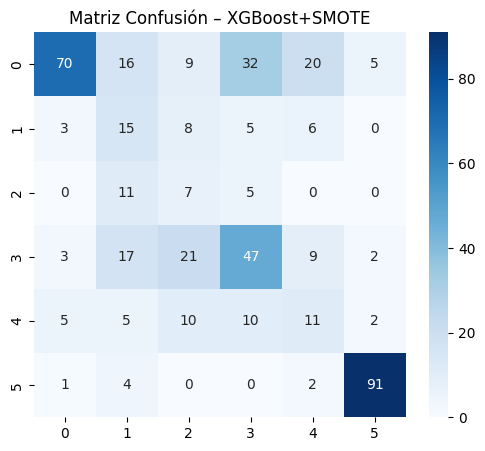

In [120]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.named_steps['xgb'].classes_,
            yticklabels=model.named_steps['xgb'].classes_)
plt.title('Matriz Confusión – XGBoost+SMOTE')
plt.show()

### Matriz de Confusión – XGBoost + SMOTE
- **Insomnia (0)**  
  - **TP**: 70 (46 %)  
  - **Errores**: confundida con OSA (32), 1 (16) y 4 (20).
- **Narcolepsy (1)**  
  - **TP**: 15 (41 %)  
  - Buen aumento de detección frente a modelos anteriores.
- **No Disorder (2)**  
  - **TP**: 7 (30 %)  
  - Pasó de 0 a 7 aciertos, muestra mejora con SMOTE.
- **Obstructive Sleep Apnea (3)**  
  - **TP**: 47 (47 %)  
  - Reducción de falsos negativos vs. sin SMOTE, pero confusiones con Insomnia y “2”.
- **Restless Leg Syndrome (4)**  
  - **TP**: 11 (26 %)  
  - Ligeramente mejorado, aunque sigue bajo.
- **Sleep Apnea (5)**  
  - **TP**: 91 (93 %)  
  - Se mantiene muy alta la detección.

**Conclusión**  
- **SMOTE** ha elevado significativamente el recall de las clases minoritarias (1, 2, 4).  
- **Sleep Apnea (5)** sigue siendo la más precisa.  
- Aun así, Insomnia y OSA mantienen confusiones entre sí y con la clase “2”.  


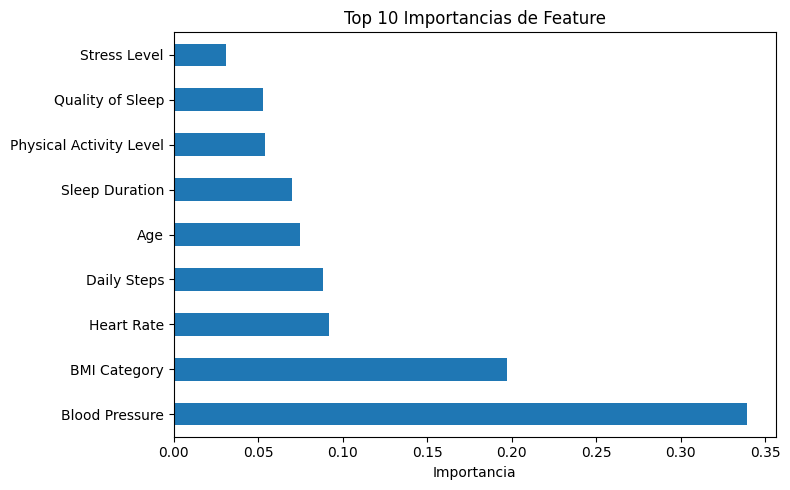

In [116]:
# Importancia de features

importances = model.named_steps['xgb'].feature_importances_
fi = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
fi.head(10).plot.barh()
plt.title('Top 10 Importancias de Feature')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

---

#### LightGBM

In [ ]:
lgbm = lgb.LGBMClassifier(random_state=42)
param_dist = {
    'n_estimators': [100,200],
    'learning_rate': [0.01,0.1,0.2],
    'num_leaves': [31, 50],
    'colsample_bytree': [0.8,1.0]
}
rnd_lgb = RandomizedSearchCV(lgbm, param_dist, cv=5, scoring='f1_weighted', n_iter=10, n_jobs=-1)
rnd_lgb.fit(X_train, y_train)
print(rnd_lgb.best_params_)
y_pred_lgb = rnd_lgb.predict(X_test)
print(classification_report(y_test, y_pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 1804, number of used features: 9
[LightGBM] [Info] Start training from score -1.092533
[LightGBM] [Info] Start training from score -2.487126
[LightGBM] [Info] Start training from score -2.954467
[LightGBM] [Info] Start training from score -1.523952
[LightGBM] [Info] Start training from score -2.361963
[LightGBM] [Info] Start training from score -1.526500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

- Sleep Apnea (5):
    - Excelente detección (F1 ≈ 0.92).
- Insomnia (0) & OSA (3):
    - Rendimiento moderado (F1 ≈ 0.62 y 0.54).
- Clases raras (1, 2, 4):
    - Muy baja cobertura (recall < 0.15 o nulo).
- Balance general vs. minorías:
    - Buena accuracy global pero bajo macro-F1 indica que las clases poco frecuentes penalizan el modelo.

